<a href="https://colab.research.google.com/github/pinkdolphin11/ESAA/blob/main/HW_1003_CustomersClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customers clustering: K-Means, DBSCAN and AP

K-Means, Affinity Propagation, DBSCAN의 3가지 비지도학습 알고리즘을 사용한 쇼핑몰 고객 군집화

## 1. Introduction

비지도학습은 unlabelled dataset에서 natural group을 찾아내는 것이다.

군집화 알고리즘의 분류

* Hierarchical algorithms(계층적 알고리즘) : subset 안에 하나의 item만 포함될 때까지 데이터를 더 작은 subset으로 나눈다. tree 형태의 dendogram으로 나타낼 수 있다. cluster 개수를 지정할 필요는 없지만, splitting/merging process를 위한 termination condition을 지정해 줘야 하낟.

* Partitional algorithms(분할적 알고리즘) : 주어진 기준에 따라 데이터를 여러 개의 subset으로 나눈다. K-Means처럼 cluster 개수를 지정해줘야 하는 경우도 있고, DBSCAN처럼 그렇지 않은 경우도 있다.

## 2. Reading data

In [8]:
# 라이브러리 불러오기
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("seaborn version: {}".format(sns.__version__))

pandas version: 1.3.5
numpy version: 1.21.6
seaborn version: 0.11.2


In [2]:
# 데이터 불러오기

from google.colab import drive
drive.mount('/content/gdrive')

mall_data = pd.read_csv('/content/gdrive/MyDrive/Mall_Customers.csv')
print('There are {} rows and {} columns in our dataset'.format(mall_data.shape[0],mall_data.shape[1]))

Mounted at /content/gdrive
There are 200 rows and 5 columns in our dataset


In [3]:
mall_data.sample(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
58,59,Female,27,46,51
127,128,Male,40,71,95
93,94,Female,40,60,40
50,51,Female,49,42,52
166,167,Male,42,86,20
82,83,Male,67,54,41
40,41,Female,65,38,35
7,8,Female,23,18,94
32,33,Male,53,33,4
176,177,Male,58,88,15


In [4]:
mall_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


데이터 column 정보

* CustomerID : numerical, unique customer number, integer
* Gender : categorical, binary(M/F)
* Age : numerical, integer
* Annual Income : numerical, integer
* Spending Score : numericla, integer

Gender에 대해 원핫인코딩을 적용할 수 있지만 권장되는 방법은 아니다.

In [5]:
mall_data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

결측치는 없다.

## 3. EDA

### 3.1 Distributions

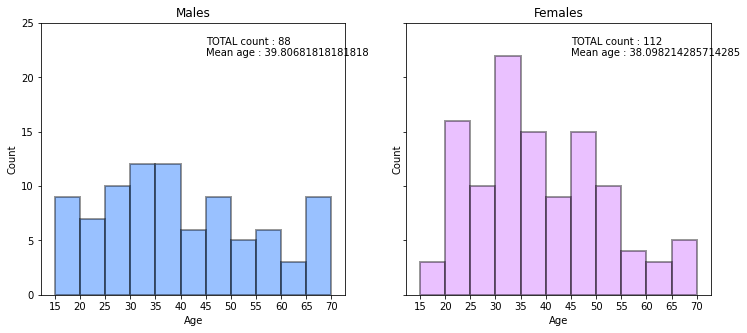

In [12]:
males_age = mall_data[mall_data['Gender']=='Male']['Age'] #subset with males age
females_age = mall_data[mall_data['Gender']=='Female']['Age'] #subset with females age

age_bins = range(15,75,5)

# males histogram
fig2, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5),sharey=True)
sns.distplot(males_age, bins=age_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(age_bins)
ax1.set_ylim(top=25)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(45,23,'TOTAL count : {}'.format(males_age.count()))
ax1.text(45,22,'Mean age : {}'.format(males_age.mean()))

# females histogram
sns.distplot(females_age, bins=age_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(age_bins)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(45,23,'TOTAL count : {}'.format(females_age.count()))
ax2.text(45,22,'Mean age : {}'.format(females_age.mean()))

plt.show()

In [13]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_age, females_age)[1]))

Kolgomorov-Smirnov test p-value: 0.49


male customer의 평균 나이가 female보다 약간 높다. male age의 분포가 female보다 더 균일하다.(uniform) 가장 많은 customer가 분포하는 age 그룹은 30-35세이다. 두 그룹 간의 차이는 통계적으로 유의하지 않다.

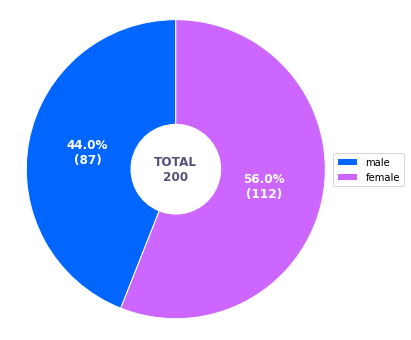

In [14]:
def labeler(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

sizes = [males_age.count(),females_age.count()] # wedge sizes

fig0, ax1 = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax1.pie(sizes,
                                   autopct=lambda pct: labeler(pct, sizes),
                                   radius=1,
                                   colors=['#0066ff','#cc66ff'],
                                   startangle=90,
                                   textprops=dict(color="w"),
                                   wedgeprops=dict(width=0.7, edgecolor='w'))

ax1.legend(wedges, ['male','female'],
           loc='center right',
           bbox_to_anchor=(0.7, 0, 0.5, 1))

plt.text(0,0, 'TOTAL\n{}'.format(mall_data['Age'].count()),
         weight='bold', size=12, color='#52527a',
         ha='center', va='center')

plt.setp(autotexts, size=12, weight='bold')
ax1.axis('equal')  # Equal aspect ratio
plt.show()

female customer가 조금 더 많다.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


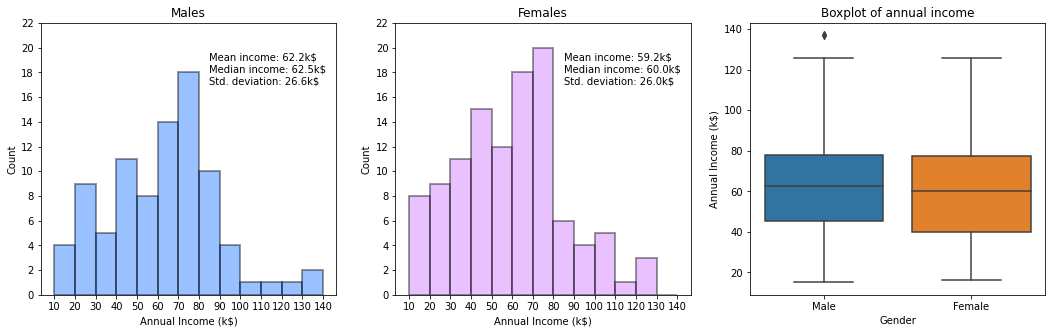

In [15]:
males_income = mall_data[mall_data['Gender']=='Male']['Annual Income (k$)'] #subset with male income
females_income = mall_data[mall_data['Gender']=='Female']['Annual Income (k$)'] #subset with female income
my_bins = range(10,150,10)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_income, bins=my_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(my_bins)
ax1.set_yticks(range(0,24,2))
ax1.set_ylim(0,22)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(85,19, "Mean income: {:.1f}k$".format(males_income.mean()))
ax1.text(85,18, "Median income: {:.1f}k$".format(males_income.median()))
ax1.text(85,17, "Std. deviation: {:.1f}k$".format(males_income.std()))

# females histogram
sns.distplot(females_income, bins=my_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(my_bins)
ax2.set_yticks(range(0,24,2))
ax2.set_ylim(0,22)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(85,19, "Mean income: {:.1f}k$".format(females_income.mean()))
ax2.text(85,18, "Median income: {:.1f}k$".format(females_income.median()))
ax2.text(85,17, "Std. deviation: {:.1f}k$".format(females_income.std()))

# boxplot
sns.boxplot(x='Gender', y='Annual Income (k$)',data=mall_data,ax=ax3)
ax3.set_title('Boxplot of annual income')
plt.show()

In [16]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_income, females_income)[1]))

Kolgomorov-Smirnov test p-value: 0.78


male의 income이 female보다 크고, median도 더 크다. sd는 비슷하다. male income에는 140k$ 정도의 값을 갖는 outlier가 있다. K-S test에 따르면 두 그룹은 통계적으로 유의하게 다르지 않다.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


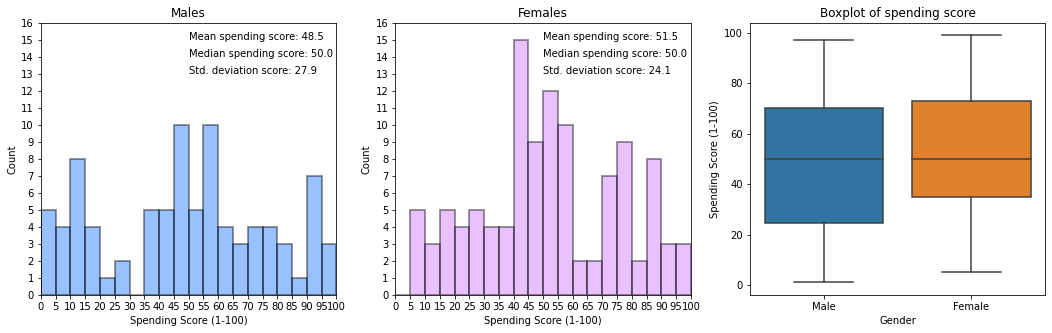

In [17]:
males_spending = mall_data[mall_data['Gender']=='Male']['Spending Score (1-100)'] # subset with males age
females_spending = mall_data[mall_data['Gender']=='Female']['Spending Score (1-100)'] # subset with females age

spending_bins = range(0,105,5)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_spending, bins=spending_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(spending_bins)
ax1.set_xlim(0,100)
ax1.set_yticks(range(0,17,1))
ax1.set_ylim(0,16)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(50,15, "Mean spending score: {:.1f}".format(males_spending.mean()))
ax1.text(50,14, "Median spending score: {:.1f}".format(males_spending.median()))
ax1.text(50,13, "Std. deviation score: {:.1f}".format(males_spending.std()))

# females histogram
sns.distplot(females_spending, bins=spending_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(spending_bins)
ax2.set_xlim(0,100)
ax2.set_yticks(range(0,17,1))
ax2.set_ylim(0,16)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(50,15, "Mean spending score: {:.1f}".format(females_spending.mean()))
ax2.text(50,14, "Median spending score: {:.1f}".format(females_spending.median()))
ax2.text(50,13, "Std. deviation score: {:.1f}".format(females_spending.std()))

# boxplot
sns.boxplot(x='Gender', y='Spending Score (1-100)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of spending score')
plt.show()

plt.show()

In [18]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_spending, females_spending)[1]))

Kolgomorov-Smirnov test p-value: 0.29


female의 spending score가 male보다 높다. 테스트에 따르면 귀무가설을 기각할 필요는 없지만, 앞선 비교처럼 증명이 필요없을 정도로 확실한 결과는 아니다.

In [19]:
# calculate median income for all age groups
medians_by_age_group = mall_data.groupby(['Gender',pd.cut(mall_data['Age'],age_bins)]).median()
medians_by_age_group.index = medians_by_age_group.index.set_names(['Gender','Age_group'])
medians_by_age_group.reset_index(inplace=True)

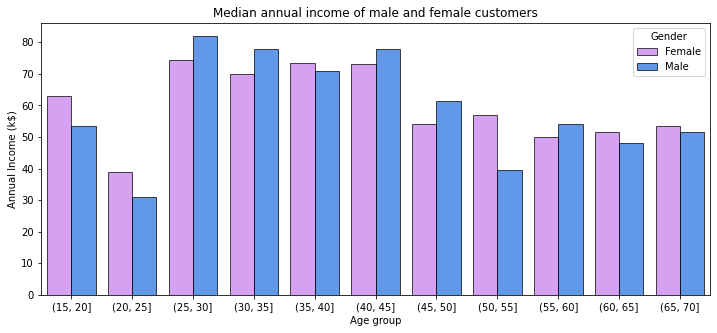

In [21]:
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x='Age_group',y='Annual Income (k$)',hue='Gender',data=medians_by_age_group,palette=['#cc66ff','#0066ff'],alpha=0.7,edgecolor='k',ax=ax)
ax.set_title('Median annual income of male and female customers')
ax.set_xlabel('Age group')
plt.show()

25-45세의 customer들의 소득수준이 가장 높고, 성별 간 차이는 25-30 구간에서 male이 더 높고, 50-55 구간에서 female이 더 높은 것으로 두드러진다.

### 3.2 Correlations

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


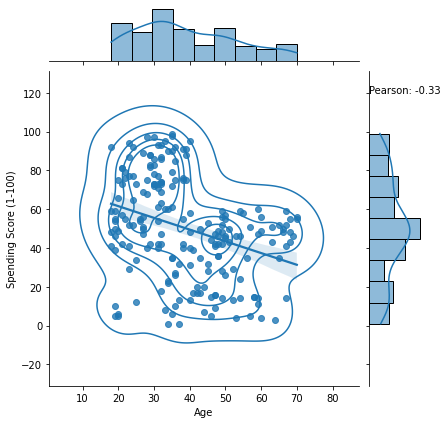

In [23]:
from scipy.stats import pearsonr

# calculating Pearson's correlation
corr, _ = pearsonr(mall_data['Age'],mall_data['Spending Score (1-100)'])

jp = (sns.jointplot('Age','Spending Score (1-100)',data=mall_data,kind='reg')).plot_joint(sns.kdeplot,zorder=0,n_levels=6)

plt.text(0,120,'Pearson: {:.2f}'.format(corr))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


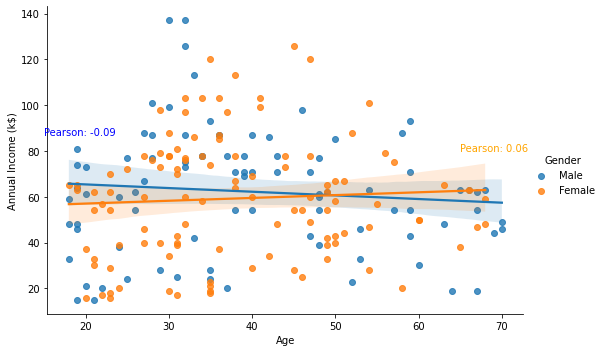

In [24]:
# calculating Pearson's correlation
corr1, _ = pearsonr(males_age.values, males_income.values)
corr2, _ = pearsonr(females_age.values, females_income.values)

sns.lmplot('Age', 'Annual Income (k$)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(15,87, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(65,80, 'Pearson: {:.2f}'.format(corr2), color='orange')

plt.show()

성별별로 age와 annual income 사이에는 관계가 없다.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


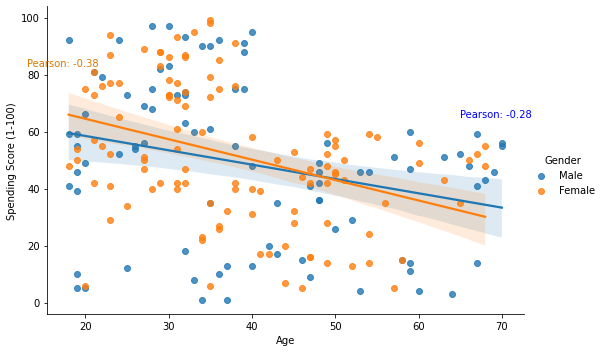

In [25]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_age.values, males_spending.values)
corr2, _ = pearsonr(females_age.values, females_spending.values)

sns.lmplot('Age', 'Spending Score (1-100)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(65,65, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(13,83, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()

성별별로 나이와 spending score 간에는 약학 반비례 관계가 있다.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


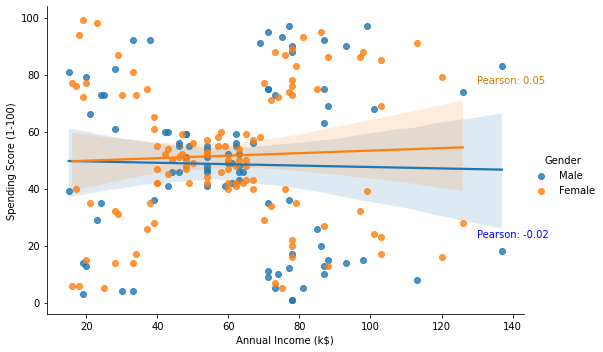

In [26]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_income.values, males_spending.values)
corr2, _ = pearsonr(females_income.values, females_spending.values)

sns.lmplot('Annual Income (k$)', 'Spending Score (1-100)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(130,23, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(130,77, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()

성별별로 annual income과 spending score 사이에는 관계가 없다.

## 4. Clustering

## 4.1 K-Means

#### 4.1.1 Description

3 main steps

1. Split samples into initial groups by using seed points. The nearest samples to these seed point will create initial clusters.

2. Calculate samples distances to groups’ central points (centroids) and assign the nearest samples to their cluster.

3. The third step is to calculate newly created (updated) cluster centroids.

Then repeat steps 2 and 3 until the algorithm converges.

3 main parameters

1. Initialisation criteria

2. Number of clusters

3. A distance metric (not required in scikit learn implementation)

#### 4.1.2 Use case - customers segmentation

In [27]:
from sklearn.cluster import KMeans 

numeric column만 필요하다.

In [29]:
X_numerics = mall_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] #subset with numeric variables only

적절한 num of cluster를 찾기 위해 elbow method를 사용했다. n_cluster 2~10까지가 계산될 것이다. 그래프의 'elbow'라고 생각되는 부분의 n_cluster를 선택하면 된다.

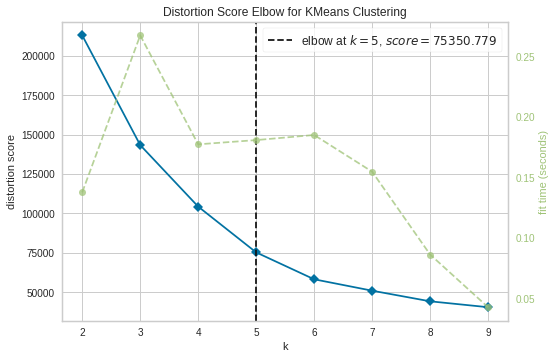

In [30]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

5~6 정도를 선택하면 될 것으로 보인다.

실루엣 점수를 보고 선택하는 방법도 있다.

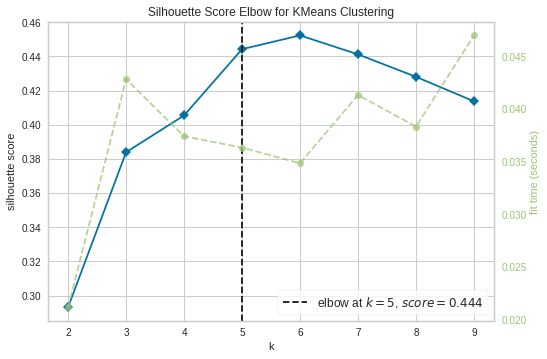

In [31]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

여기서도 5, 6이 best이므로 둘을 비교해보자.



**5 CLUSTERS**

In [32]:
KM_5_clusters = KMeans(n_clusters=5,init='k-means++').fit(X_numerics) #initialise and fit K-Means model
KM5_clustered = X_numerics.copy()
KM5_clustered.loc[:,'Cluster'] = KM_5_clusters.labels_ #append labels to points

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


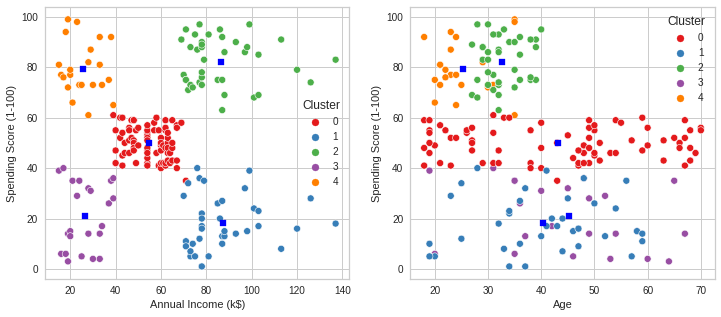

In [33]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=KM5_clustered,
                hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot('Age', 'Spending Score (1-100)', data=KM5_clustered,
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(KM_5_clusters.cluster_centers_[:,1],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_5_clusters.cluster_centers_[:,0],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

K-Means algorithm generated the following 5 clusters:

* clients with low annual income and high spending score
* clients with medium annual income and medium spending score
* clients with high annual income and low spending score
* clients with high annual income and high spending score
* clients with low annual income and low spending score 

There are no distinct groups is terms of customers age.

In [34]:
KM_clust_sizes = KM5_clustered.groupby('Cluster').size().to_frame()
KM_clust_sizes.columns = ["KM_size"]
KM_clust_sizes

,KM_size
Cluster,
0,79
1,37
2,39
3,23
4,22


The biggest cluster is a cluster number 1 with 79 observations ("medium-medium" clients). There are two the smallest ones each containing 23 observations (cluster 3 "high-high" and cluster 0 "low-high" clients).

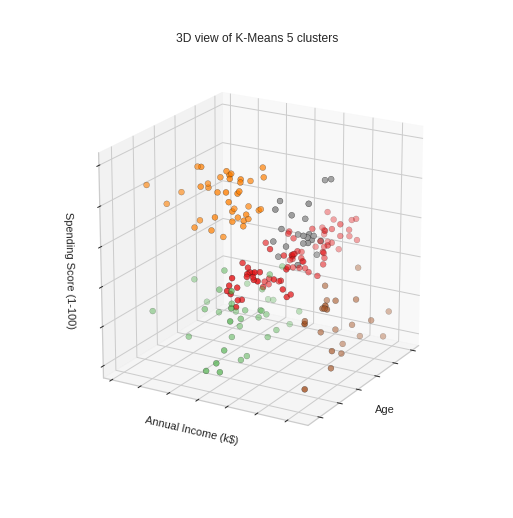

In [35]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig, rect=[0, 0, .99, 1], elev=20, azim=210)
ax.scatter(KM5_clustered['Age'],
           KM5_clustered['Annual Income (k$)'],
           KM5_clustered['Spending Score (1-100)'],
           c=KM5_clustered['Cluster'],
           s=35, edgecolor='k', cmap=plt.cm.Set1)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('3D view of K-Means 5 clusters')
ax.dist = 12

plt.show()

In [36]:
import plotly as py
import plotly.graph_objs as go

def tracer(db, n, name):
    '''
    This function returns trace object for Plotly
    '''
    return go.Scatter3d(
        x = db[db['Cluster']==n]['Age'],
        y = db[db['Cluster']==n]['Spending Score (1-100)'],
        z = db[db['Cluster']==n]['Annual Income (k$)'],
        mode = 'markers',
        name = name,
        marker = dict(
            size = 5
        )
     )

trace0 = tracer(KM5_clustered, 0, 'Cluster 0')
trace1 = tracer(KM5_clustered, 1, 'Cluster 1')
trace2 = tracer(KM5_clustered, 2, 'Cluster 2')
trace3 = tracer(KM5_clustered, 3, 'Cluster 3')
trace4 = tracer(KM5_clustered, 4, 'Cluster 4')

data = [trace0, trace1, trace2, trace3, trace4]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

실루엣 계수 그래프를 보고 각 그룹의 quality를 확인할 수 있다.

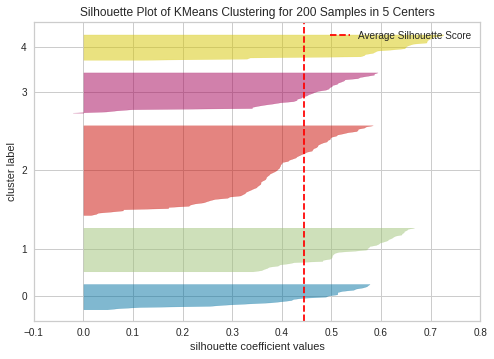

In [37]:
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(n_clusters=5,random_state=0)
visualizer = SilhouetteVisualizer(model,colors='yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

**6 CLUSTERS**

In [38]:
KM_6_clusters = KMeans(n_clusters=6, init='k-means++').fit(X_numerics) # initialise and fit K-Means model

KM6_clustered = X_numerics.copy()
KM6_clustered.loc[:,'Cluster'] = KM_6_clusters.labels_ # append labels to points

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



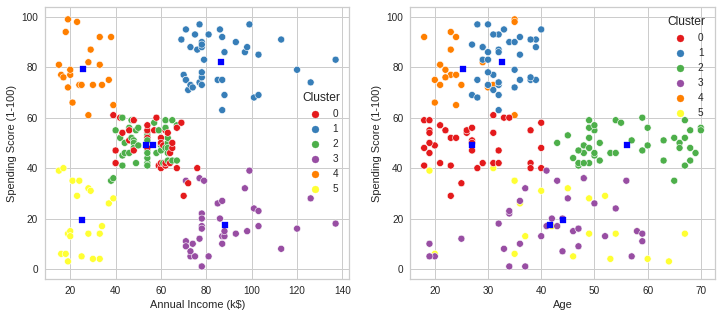

In [39]:
fig11, (axes) = plt.subplots(1,2,figsize=(12,5))

sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=KM6_clustered,
                hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot('Age', 'Spending Score (1-100)', data=KM6_clustered,
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')

# plotting centroids
axes[0].scatter(KM_6_clusters.cluster_centers_[:,1], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_6_clusters.cluster_centers_[:,0], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

K-Means algorithm generated the following 6 clusters:

* younger clients with **medium** annual and **medium** spending score
* clients with **high** annual income and **low** spending score
* younger clients with **medium** annual and **medium** spending score
* clients with **high** annual income and **high** spending score
* clients with **low** annual income and **low** spending score
* clients with **low** annual income and **high** spending score

There are no distinct groups is terms of customers age.

In [40]:
KM6_clust_sizes = KM6_clustered.groupby('Cluster').size().to_frame()
KM6_clust_sizes.columns = ["KM_size"]
KM6_clust_sizes

,KM_size
Cluster,
0,38
1,39
2,45
3,35
4,22
5,21


In [41]:
# Plotly interactive 3D plot

trace0 = tracer(KM6_clustered, 0, 'Cluster 0')
trace1 = tracer(KM6_clustered, 1, 'Cluster 1')
trace2 = tracer(KM6_clustered, 2, 'Cluster 2')
trace3 = tracer(KM6_clustered, 3, 'Cluster 3')
trace4 = tracer(KM6_clustered, 4, 'Cluster 4')
trace5 = tracer(KM6_clustered, 5, 'Cluster 5')

data = [trace0, trace1, trace2, trace3, trace4, trace5]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

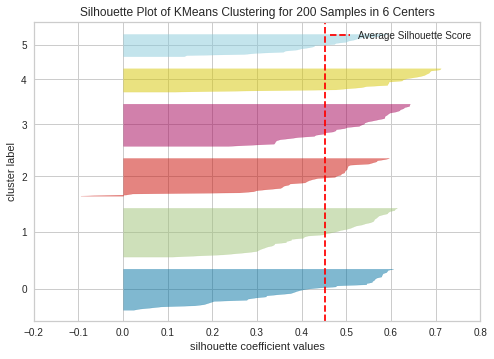

In [42]:
model = KMeans(n_clusters=6, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

### 4.2 DBSCAN

#### 4.2.1 Description



2 parameters

* Eps : epsilon distance
* MinPts : Minimum number of points within distance Eps

Advantages

* 클러스터 개수를 직접 찾아준다.
* 길쭉한 클러스터 또는 다른 클러스터로 둘러싸인 클러스터를 구별할 수 있다.
* outlier detection

Drawbacks

* high computional expense
* 다양한 density를 가진 cluster는 잘 구별하지 못함

#### 4.2.2 Use case - customers segmentation

In [43]:
from sklearn.cluster import DBSCAN

두 파라미터를 어떻게 지정해야 잘 작동하는지 알 수 없으므로, 다양한 조합에 대한 matrix를 먼저 만들었다.

In [44]:
from itertools import product

eps_values = np.arange(8,12.75,0.25) #eps values to be investigated
min_samples = np.arange(3,10) # min_samples values to be investigated

DBSCAN_params = list(product(eps_values, min_samples))

In [45]:
# Check the number of generated clusters.
from sklearn.metrics import silhouette_score

no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
  DBS_clustering = DBSCAN(eps=p[0],min_samples=p[1]).fit(X_numerics)
  no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
  sil_score.append(silhouette_score(X_numerics,DBS_clustering.labels_))

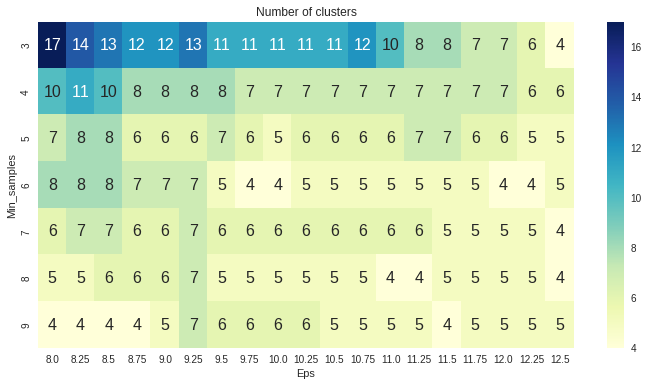

In [46]:
# heatmap : how many clusters were generated by the DBSCAN for the respective parameter combinations
tmp = pd.DataFrame.from_records(DBSCAN_params,columns=['Eps','Min_samples'])
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp,values = 'No_of_clusters',index='Min_samples',columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

17 ~ 4까지 다양하게 분포하지만 4 ~ 7이 가장 많다. 어떤 조합을 사용할지 결정하기 위해 silhouette score 히트맵을 그렸다. 

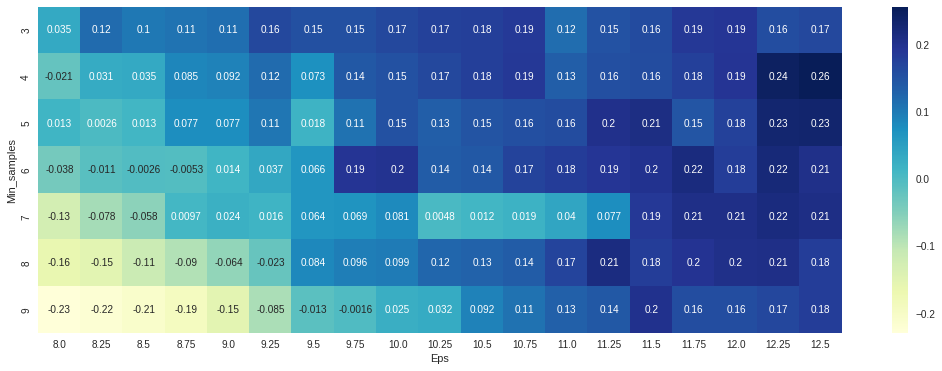

In [47]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

eps = 12.5, min_samples = 4일때 global maximum이 0.26이다.

In [48]:
DBS_clustering = DBSCAN(eps=12.5, min_samples=4).fit(X_numerics)

DBSCAN_clustered = X_numerics.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points

In [49]:
# cluster size check
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,18
0,112
1,8
2,34
3,24
4,4


DBSCAN created 5 clusters plus outliers cluster (-1). Sizes of clusters 0-4 vary significantly - some have only 4 or 8 observations. There are 18 outliers.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



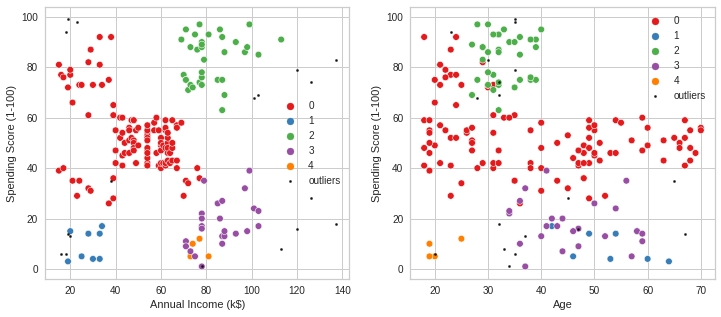

In [50]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]

fig2, (axes) = plt.subplots(1,2,figsize=(12,5))


sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', ax=axes[0], palette='Set1', legend='full', s=45)

sns.scatterplot('Age', 'Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', palette='Set1', ax=axes[1], legend='full', s=45)

axes[0].scatter(outliers['Annual Income (k$)'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[1].scatter(outliers['Age'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[0].legend()
axes[1].legend()

plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')

plt.show()

There are some outliers.

### 4.3 Affinity Propagation

#### 4.3.1 Description

2 parameters

* **Preference** which is a negative number and controls how many exemplars are used.

* **Damping factor** which prevents numerical oscillations when updating messages.

#### 4.3.2 Use case

In [51]:
from sklearn.cluster import AffinityPropagation

In [56]:
no_of_clusters = []
preferences = range(-20000,-5000,200) 
af_sil_score = [] 

for p in preferences:
    AF = AffinityPropagation(preference=p, max_iter=200).fit(X_numerics)
    no_of_clusters.append((len(np.unique(AF.labels_))))
    af_sil_score.append(silhouette_score(X_numerics, AF.labels_))
    
af_results = pd.DataFrame([preferences, no_of_clusters, af_sil_score], index=['preference','clusters', 'sil_score']).T
af_results.sort_values(by='sil_score', ascending=False).head()

,preference,clusters,sil_score
41,-11800.0,6.0,0.451649
63,-7400.0,6.0,0.451440
26,-14800.0,6.0,0.451440
46,-10800.0,6.0,0.451440
14,-17200.0,6.0,0.451440


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



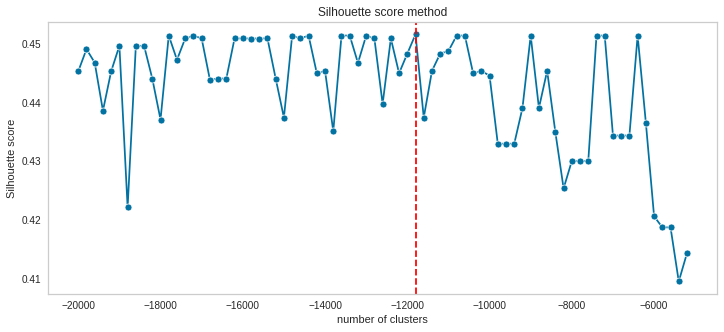

In [57]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(preferences, af_sil_score, marker='o', ax=ax)
ax.set_title("Silhouette score method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
ax.axvline(-11800, ls="--", c="red")
plt.grid()
plt.show()

In [58]:
AF = AffinityPropagation(preference=-11800).fit(X_numerics)

In [59]:
AF_clustered = X_numerics.copy()
AF_clustered.loc[:,'Cluster'] = AF.labels_ # append labels to points

In [60]:
AF_clust_sizes = AF_clustered.groupby('Cluster').size().to_frame()
AF_clust_sizes.columns = ["AF_size"]
AF_clust_sizes

,AF_size
Cluster,
0,22
1,22
2,44
3,39
4,34
5,39


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



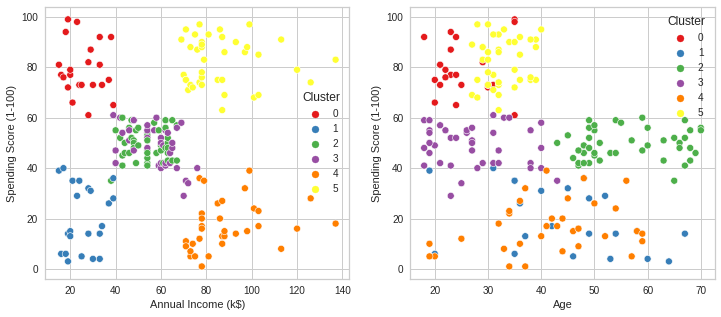

In [61]:
fig3, (ax_af) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', ax=ax_af[0], palette='Set1', legend='full')

sns.scatterplot('Age', 'Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', palette='Set1', ax=ax_af[1], legend='full')

plt.setp(ax_af[0].get_legend().get_texts(), fontsize='10')
plt.setp(ax_af[1].get_legend().get_texts(), fontsize='10')
plt.show()

K-Means로 만들어진 것과 비슷한 짝수 크기의 cluster를 만들었다.

## 5. Comparison and discussion

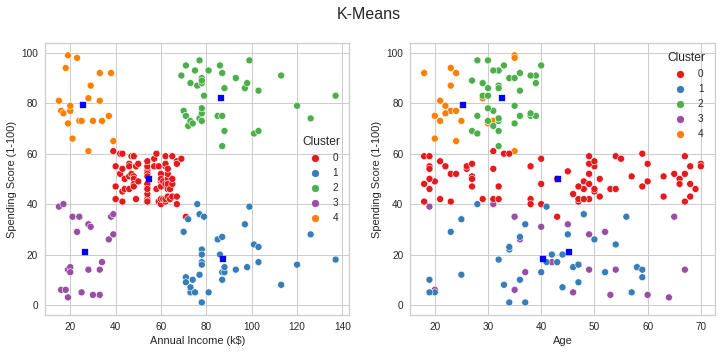

In [62]:
fig1.suptitle('K-Means', fontsize=16)
fig1

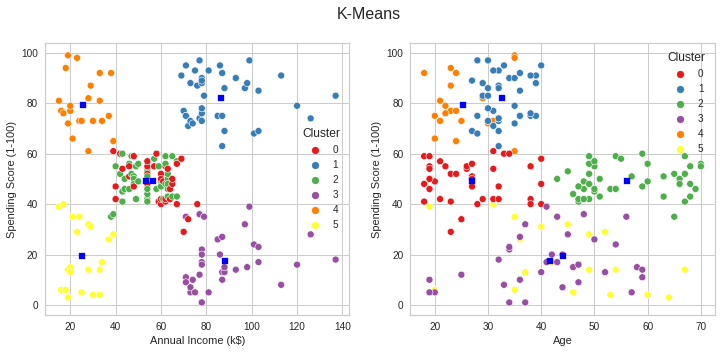

In [63]:
fig11.suptitle('K-Means', fontsize=16)
fig11

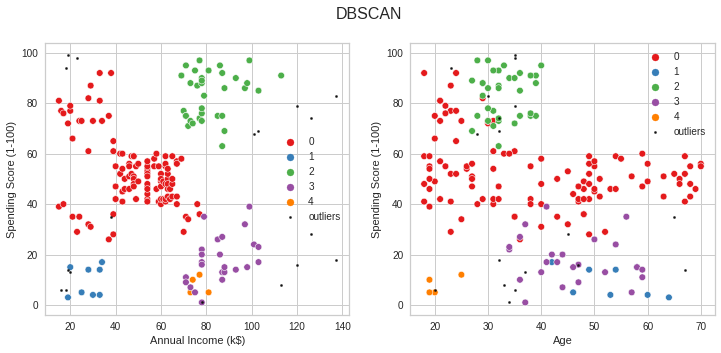

In [64]:
fig2.suptitle('DBSCAN', fontsize=16)
fig2

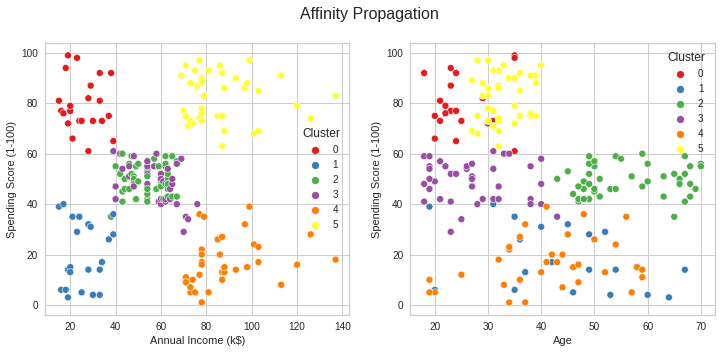

In [65]:
fig3.suptitle('Affinity Propagation', fontsize=16)
fig3

아래 표는 만들어진 cluster size를 보여준다.

In [66]:
clusters = pd.concat([KM6_clust_sizes, DBSCAN_clust_sizes, AF_clust_sizes],axis=1, sort=False)
clusters

,KM_size,DBSCAN_size,AF_size
Cluster,,,
-1,NaN,18.0,NaN
0,38.0,112.0,22.0
1,39.0,8.0,22.0
2,45.0,34.0,44.0
3,35.0,24.0,39.0
4,22.0,4.0,34.0
5,21.0,NaN,39.0


위 표를 보면 DBSCAN은 적절하지 않다. density of points에 기반해서 cluster를 찾기 때문에 cluster 중 하나가 다른 것보다 밀도가 작으면 DBSCAN은 그 least dense group을 cluster로 인식하지 않는다. 그래서 부적절한 결과가 나온 것이라고 볼 수 있다.

따라서 K-Means와 Affinity Propagation이 적절하고, 이 알고리즘들은 6개의 cluster로 mall_data를 군집화하였다.